In [1]:
%pip install category_encoders
%pip install optuna
%pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from category_encoders import TargetEncoder
from imblearn.under_sampling import RandomUnderSampler
import time
import os
import joblib
import optuna

In [5]:
df = pd.read_csv('train.csv', index_col='id')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
X = df.drop("Response", axis=1)
y = df["Response"]

### Трансформер для предобработки признаков

В данных есть категориальные признаки, которые требуют преобразований.

Для каждого из них применим подходящую предобработку:
- для признаков с высокой кардинальностью: Region_Code и Policy_Sales_Channel - TargetEncoder (риски переобучения будем снижать кросс-валидацией)
- для бинарных признаков: Gender и Vehicle_Damage - OneHotEncoder
- для признака Vehicle_Age для которого порядок имеет смысл - OrdinalEncoder в следующем порядке: ['< 1 Year', '1-2 Year', '> 2 Years']

In [14]:
policy_cols = ['Policy_Sales_Channel']
region_cols = ['Region_Code']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

policy_encoder = TargetEncoder(
    cols=policy_cols,
    smoothing=20,          # для Policy_Sales_Channel с 11 млн строк
    min_samples_leaf=5000, # 0.045% от 11 млн
    handle_unknown='value',
    handle_missing='value'
)
region_encoder = TargetEncoder(cols=region_cols)
bool_encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
ord_encoder = OrdinalEncoder(categories = [['< 1 Year', '1-2 Year', '> 2 Years']], dtype=int)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("policy_encoder", policy_encoder, policy_cols),
        ("region_encoder", region_encoder, region_cols),
        ("bool", bool_encoder, bool_cols),
        ("ord", ord_encoder, ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
).set_output(transform='pandas')

In [16]:
preprocessor.fit(X, y)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('policy_encoder',
                                 TargetEncoder(cols=['Policy_Sales_Channel'],
                                               min_samples_leaf=5000,
                                               smoothing=20),
                                 ['Policy_Sales_Channel']),
                                ('region_encoder',
                                 TargetEncoder(cols=['Region_Code']),
                                 ['Region_Code']),
                                ('bool',
                                 OneHotEncoder(drop='first',
                                               dtype=<class 'int'>,
                                               sparse_output=False),
                                 ['Gender', 'Vehicle_Damage']),
                                ('ord',
                                 OrdinalEncoder(categories=[['< 1 Year',
                                                             '1-2 Year',
                                                             '> 2 Years']],
                                                dtype=<class 'int'>),
                                 ['Vehicle_Age'])],
                  verbose_feature_names_out=False)

In [20]:
X_transformed = preprocessor.transform(X) 

In [22]:
X_transformed.head()

,Policy_Sales_Channel,Region_Code,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage
id,,,,,,,,,,
0,0.192496,0.121274,1,1,1,21,1,0,65101.0,187
1,0.207763,0.191811,1,1,2,43,1,0,58911.0,288
2,0.026222,0.085700,0,0,0,25,1,1,38043.0,254
3,0.204927,0.102073,0,1,1,35,1,0,2630.0,76
4,0.026222,0.067435,0,0,1,36,1,1,31951.0,294


### Устранение дисбаланса с помощью undersampling

In [29]:
rus = RandomUnderSampler(
    sampling_strategy='auto',
    random_state=42,
    replacement=False
)

In [30]:
X_balanced, y_balanced = rus.fit_resample(X_transformed, y)

In [33]:
print("Сбалансированная выборка:\n", y_balanced.value_counts(normalize=True), sep="")

Сбалансированная тренировочная выборка:
Response
0    0.5
1    0.5
Name: proportion, dtype: float64
<class 'pandas.core.series.Series'>
Index: 2830118 entries, 9312666 to 11504796
Series name: Response
Non-Null Count    Dtype
--------------    -----
2830118 non-null  int64
dtypes: int64(1)
memory usage: 43.2 MB


### Разделение выборок

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, 
    train_size=1000000, 
    stratify=y_balanced,
    random_state=42
)
print("Тренировочная выборка:\n", y_train.value_counts(normalize=True), sep="")
print("Тестовая выборка:\n", y_test.value_counts(normalize=True), sep="")
y_train.info(verbose=True, show_counts=True)

Тренировочная выборка:
Response
0    0.5
1    0.5
Name: proportion, dtype: float64
Тестовая выборка:
Response
1    0.5
0    0.5
Name: proportion, dtype: float64
<class 'pandas.core.series.Series'>
Index: 1000000 entries, 4573663 to 6264564
Series name: Response
Non-Null Count    Dtype
--------------    -----
1000000 non-null  int64
dtypes: int64(1)
memory usage: 15.3 MB


### Модель градиентного бустинга

In [59]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
base_model = GradientBoostingClassifier(random_state=42, verbose=0)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='recall',
    cv=2,
    n_jobs=-1,
    verbose=1,
    refit=True
)
GRIDSEARCH_FILE = 'gridsearch_result.pkl'

In [64]:
if os.path.exists(GRIDSEARCH_FILE):
    print("Загружаем сохраненный GridSearch...")
    grid_search = joblib.load(GRIDSEARCH_FILE)
    print("GridSearch загружен")
else:
    print("Запуск GridSearchCV...")
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    print(f"GridSearch завершен за {(end_time - start_time)/60:.1f} минут")
    joblib.dump(grid_search, GRIDSEARCH_FILE)
    
print("\nЛучшие параметры (по Recall):")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"Лучший Recall (CV score): {grid_search.best_score_:.4f}")

Загружаем сохраненный GridSearch...
GridSearch загружен

Лучшие параметры (по Recall):
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 200
Лучший Recall (CV score): 0.9455


              precision    recall  f1-score   support

           0       0.92      0.66      0.77    500000
           1       0.73      0.95      0.83    500000

    accuracy                           0.80   1000000
   macro avg       0.83      0.80      0.80   1000000
weighted avg       0.83      0.80      0.80   1000000



<Axes: >

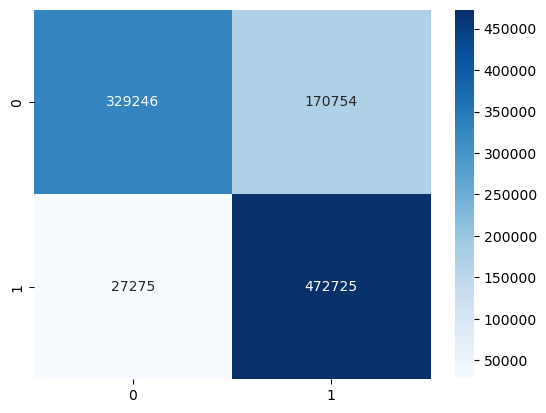

In [63]:
y_pred = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=2, n_jobs=-1)

report = classification_report(y_train, y_pred)
print(report)

sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')